## Setup

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from PIL import Image
import seaborn as sns
import numpy as np

X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

In [ ]:
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=5000, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X = X.astype(float)
X = X / X.max()

In [ ]:
X.shape

(70000, 784)

In [ ]:
from dataclasses import dataclass
import numpy as np


# Computational graphs.

class Variable:
    def __init__(self, data, terminal=False):

        self.data = np.array(data)                        # x.
        self.grad = np.zeros_like(self.data)              # dL/dx.
        self.terminal = terminal
        self.backward = int

    def __repr__(self):
        return f'Variable({self.data})'


class Function:
    def __call__(self, *variables):
        result = self.forward(*variables)                 # Forward pass, f(x0, ..., xn).

        def backward(grad = 1):                           # Backward pass.
            self.backward(*variables, grad + result.grad) # Accumulate gradients, dL/dxi += dL/df * df/dxi.

            for variable in variables:                    # Recurse.
                variable.backward(0)

            result.grad *= result.terminal                # Reset gradients.
        result.backward = backward

        return result


# Paramters.

from typing import Iterator

class Tape:

    def parameter(self, x):
        if isinstance(self.tape, Iterator):
            return next(self.tape)
        return self.tape.append(x) or x

    def run(self, f, x, tape = None):
        self.tape = tape and iter(tape) or []
        return f(x), self.tape


tape = Tape()


def Parameter(x):
    return tape.parameter(Variable(x, terminal=1))


# Nerual network components.

class Add(Function):

    def forward(self, x, y):
        return Variable(x.data + y.data)

    def backward(self, x, y, grad):
        x.grad += grad
        y.grad += grad




class ReLU(Function):

    def forward(self, x):
        return Variable(x.data * (x.data > 0))

    def backward(self, x: Variable, grad):
        x.grad += grad * (x.data > 0)




class Sin(Function):

    def forward(self, x):
        return Variable(np.sin(x.data))

    def backward(self, x, grad):
        x.grad += np.cos(x.data) * grad



@dataclass
class Optimizer:
    parameters: tuple

    def zero_grad(self):
        for parameter in self.parameters:
            parameter.grad *= 0.

    def step(self):
        raise NotImplementedError()

@dataclass
class SGD(Optimizer):
    learning_rate: float = 1e-3

    def step(self):
        for parameter in self.parameters:
            parameter.data -= parameter.grad * self.learning_rate

class Sigmoid(Function):

    def sigmoid(self, x):
        #if x < 0:
        #x = np.clip(x, 1e-9, 1 - 1e-9)
        return 1 / (1 + np.exp(-x))

    def forward(self, x: Variable) -> Variable:
        y = self.sigmoid(x.data)
        return Variable(y)

    def backward(self, x: Variable, grad: np.array) -> None:
        y = self.sigmoid(x.data)
        dx = y * (1 - y) * grad
        x.grad += dx

In [ ]:
class Linear(Function):
    """Linear layer."""

    def __init__(self, width = 2, height = 1):
        std = np.sqrt(2 / (width + height))
        self.w = Parameter(np.random.normal(0, std, size=(height, width)))
        self.b = Parameter(np.random.normal(0, std, size=(height, )))

    def forward(self, x):
        return Variable(x.data @ self.w.data.T + self.b.data)

    def backward(self, x, grad):
        self.w.grad += grad.T @ x.data
        self.b.grad += np.sum(grad, axis=0)
        x.grad += grad @ self.w.data

class MSELoss(Function):

    def forward(self, y_pred: Variable, y_true: Variable) -> Variable:
        assert y_pred.data.shape == y_true.data.shape
        self.diff = y_pred.data - y_true.data

        loss = Variable(0.5 * np.mean(self.diff**2))
        return loss

    def backward(self, y_pred: Variable, y_true: Variable, grad) -> None:
        y_pred.grad += (grad * self.diff) / self.diff.size



In [ ]:
import torch
import torch.nn as nn

# test

In [ ]:
#@markdown
# Data.
examples = 10
in_dimension = 28 * 28
hidden_dimension_0 = 100
hidden_dimension_1 = 50
hidden_dimension_2 = 2
out_dimension = 28 * 28

rx = torch.rand(examples, in_dimension)
ry = (torch.rand(examples, out_dimension) < 0.5).float()
ax = Variable(rx.numpy())
ay = Variable(ry.numpy())

# Model.

r_model = nn.Sequential(
    nn.Linear(in_dimension, hidden_dimension_0),
    nn.ReLU(),
    nn.Linear(hidden_dimension_0, hidden_dimension_1),
    nn.ReLU(),
    nn.Linear(hidden_dimension_1, hidden_dimension_2),
    nn.ReLU(),
    nn.Linear(hidden_dimension_2, hidden_dimension_1),
    nn.ReLU(),
    nn.Linear(hidden_dimension_1, hidden_dimension_0),
    nn.ReLU(),
    nn.Linear(hidden_dimension_0, out_dimension),
    nn.Sigmoid(),
)

def a_model(x):
  x = Linear(in_dimension, hidden_dimension_0)(x)
  x = ReLU()(x)
  x = Linear(hidden_dimension_0, hidden_dimension_1)(x)
  x = ReLU()(x)
  x = Linear(hidden_dimension_1, hidden_dimension_2)(x)
  x = ReLU()(x)
  x = Linear(hidden_dimension_2, hidden_dimension_1)(x)
  x = ReLU()(x)
  x = Linear(hidden_dimension_1, hidden_dimension_0)(x)
  x = ReLU()(x)
  x = Linear(hidden_dimension_0, out_dimension)(x)
  x = Sigmoid()(x)

  return x

r_parameters = list(r_model.parameters())
a_parameters = [Variable(v.detach().numpy(), terminal=1) for v in r_parameters]

for i, p in reversed(list(enumerate(a_parameters))):
  print(f'P{i}', p.data.mean(), p.data.var())

# Backprop.

r_loss_fn = nn.MSELoss()
a_loss_fn = MSELoss()

r_pred = r_model(rx)
a_pred, _ = tape.run(a_model, ax, a_parameters)

r_loss = r_loss_fn(r_pred, ry)
a_loss = a_loss_fn(a_pred, ay)

r_loss.backward()
a_loss.backward()

print('r pred:')
print(r_pred.detach().numpy())
print('a pred:')
print(a_pred.data)
print()
print('r loss:', r_loss.item())
print('a loss:', a_loss.data)

for i, p in reversed(list(enumerate(a_parameters))):
  print()
  print(f'r grad P{i}', r_parameters[i].grad.mean(), r_parameters[i].grad.var())
  print(f'a grad P{i}', a_parameters[i].grad.mean(), a_parameters[i].grad.var())

P11 -0.00018397605 0.003288448
P10 -0.00029906584 0.003338931
P9 -0.012159282 0.005752138
P8 -0.00066049193 0.006633484
P7 0.03410855 0.17768013
P6 -0.0076589356 0.1589859
P5 0.122654684 0.00023876998
P4 0.0042739953 0.008385874
P3 -0.00033903943 0.0031619987
P2 5.5723667e-06 0.0032703949
P1 0.0011765161 0.000382781
P0 4.5745073e-05 0.0004254272
r pred:
[[0.45698717 0.5048931  0.52064794 ... 0.51172674 0.5450633  0.47057155]
 [0.45752263 0.5045011  0.52091604 ... 0.51167977 0.54489815 0.4700206 ]
 [0.45906517 0.5035039  0.5216814  ... 0.5122467  0.5442691  0.4686582 ]
 ...
 [0.45654306 0.50519705 0.52040833 ... 0.51178163 0.54518384 0.47104043]
 [0.45765343 0.5043995  0.5209826  ... 0.51170015 0.5448381  0.46987706]
 [0.4567496  0.5045793  0.5209326  ... 0.512326   0.5447187  0.4701563 ]]
a pred:
[[0.45698717 0.5048931  0.52064794 ... 0.51172674 0.5450633  0.47057155]
 [0.45752263 0.5045011  0.52091604 ... 0.51167977 0.54489815 0.4700206 ]
 [0.45906517 0.5035039  0.5216814  ... 0.51224

In [ ]:
x, p = tape.run(Linear(2, 1), np.ones((1, 2)), ())

StopIteration: ignored

In [ ]:
# def Encoder():
#     linear0 = Linear(28 * 28, 100)
#     linear1 = Linear(100, 50)
#     linear2 = Linear(50, 2)

#     def model(x):
#         x = ReLU()(linear0(x))
#         x = ReLU()(linear1(x))
#         x = ReLU()(linear2(x))

#         return x
#     return model

# def Decoder():
#     linear0 = Linear(2, 50)
#     linear1 = Linear(50, 100)
#     linear2 = Linear(100, 28 * 28)

#     def model(x):
#         x = ReLU()(linear0(x))
#         x = ReLU()(linear1(x))
#         x = Sigmoid()(linear2(x))

#         return x
#     return model


class Autoencoder:

  @model
  def encode(self, x):
    ...

  @model
  def decode(self, x):
    ...

  def __call__(self, x):
    x = self.decode(self.encode(x))



def autoencoder(x):
    x = Linear(28 * 28, 100)(x)
    x = ReLU()(x)
    x = Linear(100, 50)(x)
    x = ReLU()(x)
    x = Linear(50, 2)(x)
    x = ReLU()(x)
    x = Linear(2, 50)(x)
    x = ReLU()(x)
    x = Linear(50, 100)(x)
    x = ReLU()(x)
    x = Linear(100, 28 * 28)(x)
    x = Sigmoid()(x)
    return x
# class Autoencoder:

#     def __call__(self, x):
#         self.encoder = Encoder()
#         self.decoder = Decoder()

#         x = self.encoder(x)
#         x = self.decoder(x)

#         return x

In [ ]:
def MLP(x):
  x = Linear(2, 3)(x)
  x = ReLU()(x)
  x = Linear(3, 1)(x)
  x = Sigmoid()(x)

  return x

In [ ]:
_, parameters = tape.run(MLP, np.zeros((1, 2)))
criterion = MSELoss()
optimizer = SGD(parameters, learning_rate=10)

In [ ]:
X = np.array([
    [0., 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y = np.array([[0, 1, 1, 0.]]).transpose()

epochs = 2000

for epoch in range(epochs):

    X_batch = Variable(X)
    yp, _ = tape.run(MLP, X_batch, parameters)

    optimizer.zero_grad()
    loss = criterion(yp, Variable(y))
    loss.backward()
    optimizer.step()

In [ ]:
tape.run(MLP, Variable(X), parameters)[0].data.round()


array([[0.],
       [1.],
       [1.],
       [0.]])

In [ ]:
epochs = 20
batch_size = 200
number_of_batches = X.shape[0] // batch_size

for epoch in range(epochs):
    mean_loss = 0

    for batch_number in range(number_of_batches):

        X_batch = Variable(X[batch_number * batch_size : (batch_number + 1) * batch_size])
        X_predicted, _ = tape.run(autoencoder, X_batch, parameters)

        optimizer.zero_grad()
        loss = criterion(X_predicted, X_batch)
        loss.backward()
        optimizer.step()

        mean_loss += loss.data

    print(f'Epoch: {epoch} [{batch_number+1}/{number_of_batches}] loss: {mean_loss / batch_size}')

Epoch: 0 [350/350] loss: 0.06693495778587906
Epoch: 1 [350/350] loss: 0.06611628285073104
Epoch: 2 [350/350] loss: 0.06582669769699248
Epoch: 3 [350/350] loss: 0.06565561231067375
Epoch: 4 [350/350] loss: 0.06542617422977254
Epoch: 5 [350/350] loss: 0.06531616795334526
Epoch: 6 [350/350] loss: 0.0651045306207215
Epoch: 7 [350/350] loss: 0.06510597582436072
Epoch: 8 [350/350] loss: 0.06493725713886316
Epoch: 9 [350/350] loss: 0.0647802057843916
Epoch: 10 [350/350] loss: 0.06470266049516792
Epoch: 11 [350/350] loss: 0.06455497532510572
Epoch: 12 [350/350] loss: 0.06450620578737132
Epoch: 13 [350/350] loss: 0.06461529661883701
Epoch: 14 [350/350] loss: 0.06432701084647123
Epoch: 15 [350/350] loss: 0.06435411722056783
Epoch: 16 [350/350] loss: 0.0645497227495448
Epoch: 17 [350/350] loss: 0.06408029809263813
Epoch: 18 [350/350] loss: 0.06410529487142566
Epoch: 19 [350/350] loss: 0.06443957599493694


In [ ]:
Xt_batch = X_train[0 : 256]

In [ ]:
Image.fromarray((tape.run(autoencoder, Xt_batch, parameters)[0].data[95].reshape(28, 28) * 255).astype('uint8'))

Approximating the latent discribution by fitting a 2-variable Gaussian to the encoded images.

In [ ]:


def encode(x):
  x = Linear(28 * 28, 100)(x)
  x = ReLU()(x)
  x = Linear(100, 50)(x)
  x = ReLU()(x)
  x = Linear(50, 2)(x)
  x = ReLU()(x)
  return x

encoded, _ = tape.run(encode, Variable(X[: 20_000]), parameters)
encoded = encoded.data

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
prior = KernelDensity().fit(encoded)
prior

KernelDensity()

<Axes: xlabel='x', ylabel='y'>

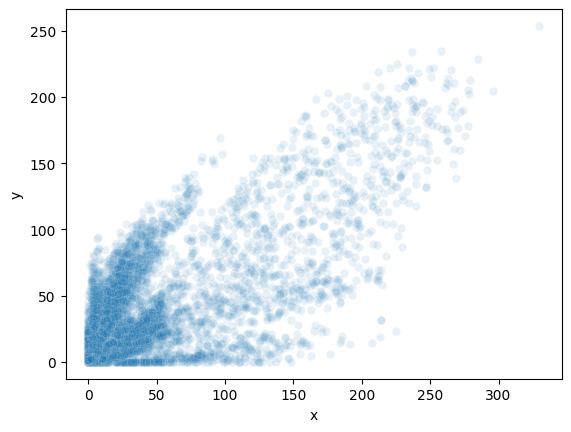

In [ ]:
import seaborn as sns
import pandas as pd

sns.scatterplot(pd.DataFrame(encoded, columns=['x', 'y']), x='x', y='y', alpha=0.1)

<Axes: xlabel='x', ylabel='y'>

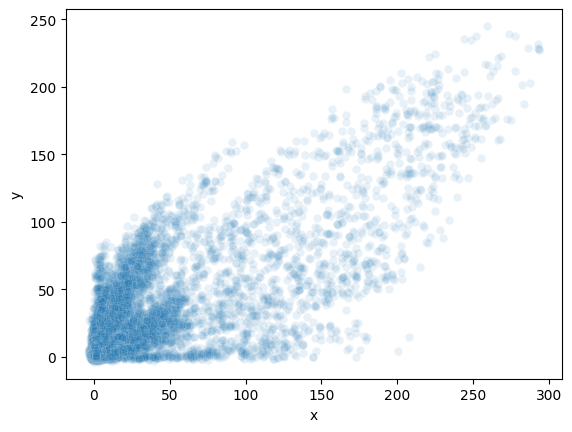

In [ ]:
prior_samples = prior.sample(20_000)
sns.scatterplot(pd.DataFrame(prior_samples, columns=['x', 'y']), x='x', y='y', alpha=0.1)

In [ ]:
_, decoder_parameters = tape.run(encode, np.ones((1, 28 * 28)), parameters)
decoder_parameters = list(decoder_parameters)

In [ ]:
def decode(x):
  x = Linear(2, 50)(x)
  x = ReLU()(x)
  x = Linear(50, 100)(x)
  x = ReLU()(x)
  x = Linear(100, 28 * 28)(x)
  x = Sigmoid()(x)
  return x

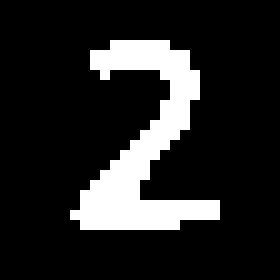

In [ ]:
#i,_ = tape.run(decode, Variable(np.random.multivariate_normal(mu, cov, 20)), decoder_parameters)
i,_ = tape.run(decode, Variable(prior.sample(10)), decoder_parameters)
Image.fromarray(((i.data[0].reshape(28, 28) > 0.5)* 255).astype('uint8').repeat(10, 0).repeat(10,1))

In [ ]:
import pickle

#pickle.dump([d.data for d in parameters], open('./autoencoder-checkpoint-7-0.064.pkl', 'wb'), )

In [ ]:
parameters_d = pickle.load(open('./autoencoder-checkpoint-7-0.064.pkl', 'rb'))

In [ ]:
parameters = [Variable(p) for p in parameters_d]#Variable(parameters_d, terminal=1)

In [ ]:
parameters

Variable([array([[-0.10519771,  0.02868726, -0.06560625, ...,  0.0280152 ,
          0.0575392 , -0.04289904],
        [ 0.03080115, -0.00017501, -0.00356841, ...,  0.03112086,
         -0.06542308, -0.02493114],
        [ 0.00866602,  0.00122523, -0.04695349, ..., -0.07051742,
          0.05865584,  0.02828879],
        ...,
        [ 0.0904564 , -0.09533772, -0.01721399, ...,  0.01081126,
          0.0263533 ,  0.05857747],
        [-0.06747646,  0.09786996, -0.07080576, ...,  0.01589933,
          0.08370035,  0.03824857],
        [ 0.04275842, -0.03821969, -0.08920456, ..., -0.01639817,
         -0.03680322,  0.05663038]])
 array([ 0.09822397,  1.37622015, -0.31084485, -2.45829634, -2.39026081,
        -0.46966988, -1.62123343,  0.04905895, -0.03836994, -1.2967296 ,
        -0.15273599, -1.21474999, -0.28770212, -0.1969908 , -3.37893797,
        -2.29470912, -0.14756303, -0.32313594,  0.20584017,  1.49863963,
        -1.60622861,  1.79705003, -0.83690997, -0.58651886, -2.08285242,


In [ ]:
parameters[4].grad.max()

In [ ]:
len(parameters)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
#@markdown
Autoencoder2 = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.ReLU(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 100),
    nn.ReLU(),
    nn.Linear(100, 28 * 28),
    nn.Sigmoid()
)

In [ ]:
#@markdown
#autoencoder = Autoencoder()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(Autoencoder2.parameters(), lr=1e-2)
Xt = torch.from_numpy(X).float()

epochs = 20
batch_size = 200
number_of_batches = Xt.shape[0] // batch_size

for epoch in range(epochs):
    mean_loss = 0

    for batch_number in range(number_of_batches):

        Xt_batch = Xt[batch_number * batch_size : (batch_number + 1) * batch_size]
        Xt_predicted = Autoencoder2(Xt_batch)

        optimizer.zero_grad()
        loss = criterion(Xt_predicted, Xt_batch)
        loss.backward()
        optimizer.step()

        mean_loss += loss.item()

    print(f'Epoch: {epoch} [{batch_number+1}/{number_of_batches}] loss: {mean_loss / batch_size}')

Epoch: 0 [350/350] loss: 0.3479941331595182
Epoch: 1 [350/350] loss: 0.2604820155352354
Epoch: 2 [350/350] loss: 0.25121980302035807
Epoch: 3 [350/350] loss: 0.24656522318720817
Epoch: 4 [350/350] loss: 0.24346791841089727
Epoch: 5 [350/350] loss: 0.24138582818210125
Epoch: 6 [350/350] loss: 0.24012208439409732
Epoch: 7 [350/350] loss: 0.2389926716685295
Epoch: 8 [350/350] loss: 0.23759655214846134
Epoch: 9 [350/350] loss: 0.23656745567917825
Epoch: 10 [350/350] loss: 0.23599641136825084
Epoch: 11 [350/350] loss: 0.23577209159731866
Epoch: 12 [350/350] loss: 0.23541051778942346
Epoch: 13 [350/350] loss: 0.2344339432194829
Epoch: 14 [350/350] loss: 0.23405462093651294
Epoch: 15 [350/350] loss: 0.23362225268036127
Epoch: 16 [350/350] loss: 0.23276252478361129
Epoch: 17 [350/350] loss: 0.23271583821624517
Epoch: 18 [350/350] loss: 0.2326565131917596
Epoch: 19 [350/350] loss: 0.2320362423360348


In [ ]:
Image.fromarray((Autoencoder2(Xt_batch)[94].reshape(28, 28) * 255).detach().numpy().astype('uint8'))

In [ ]:
f=next(Autoencoder2.parameters())

In [ ]:
f.max()

In [ ]:
len(r_parameters)

In [ ]:
0.11001735*2